- https://keras.io/examples/timeseries/timeseries_traffic_forecasting/#graph-convolution-layer
- https://towardsdatascience.com/time-series-forecasting-with-graph-convolutional-neural-network-7ffb3b70afcf

In [2]:
%load_ext autoreload
%autoreload 2

import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

from utils.base_helpers import read_data, split_data, scale_data, expand_data
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import typing

2022-04-22 21:41:38.080934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 21:41:38.080953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [28]:
# without feature
df, plants = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=8)
train_df_, valid_df, test_df = split_data(df, train_ratio=0.8, valid_ratio=0.1)
train_df, valid_df, test_df = expand_data(train_df_, valid_df, test_df)
train_df, valid_df, test_df = scale_data(train_df, valid_df, test_df, plants, scaler="minmax")

Train start and end dates:	 2019-01-26 03:00:00 	 2021-06-22 09:00:00
Validation start and end dates:	 2021-06-22 10:00:00 	 2021-10-10 04:00:00
Test start and end dates:	 2021-10-10 05:00:00 	 2022-01-27 23:00:00


In [29]:
from utils.tf_helpers import WindowGenerator

OUT_STEPS = 24
INPUT_WIDTH = 30

window = WindowGenerator(
    train_df=train_df, valid_df=valid_df, test_df=test_df, 
    columns=[col for col in df.columns if col != "rt_plant_id"],
    input_width=INPUT_WIDTH, label_width=OUT_STEPS, shift=0, label_columns=["production"])
window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['production']

In [30]:
class GraphInfo:
    def __init__(self, edges, num_nodes):
        self.edges = edges
        self.num_nodes = num_nodes

adjacency_matrix = pd.pivot_table(train_df_[["rt_plant_id", "production"]], columns="rt_plant_id", index="forecast_dt").corr()

adjacency_matrix = adjacency_matrix[adjacency_matrix > 0.6].fillna(0).values

node_indices, neighbor_indices = np.where(adjacency_matrix != 0)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")


number of nodes: 8, number of edges: 60


In [84]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [48]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def get_config(self):
        return super().get_config()
        

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [94]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.graph_conv2 = GraphConv(out_feat, out_feat, graph_info, **graph_conv_params)
        
        self.lstm = layers.LSTM(lstm_units, activation="relu")
        # self.lstm2 = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len, activation="sigmoid")

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_seq_len": self.input_seq_len,
            "output_seq_len": self.output_seq_len,
        })
        return config

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """
        # batch_size, input_seq_len, num_nodes, in_feat = inputs.shape
        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(inputs)
        # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out
        
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )
        print(batch_size, input_seq_len, num_nodes, in_feat)
        # LSTM takes only 3D tensors as input
        # gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        # lstm_out = self.lstm(gcn_out)  
        # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        # gcn_out = self.graph_conv2(gcn_out)
        print(batch_size, num_nodes, input_seq_len)
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, -1))
        lstm_out = self.lstm(gcn_out)  
        
        # lstm_out = self.lstm(gcn_out)  
        
        # lstm_out = tf.reshape(lstm_out, (batch_size, num_nodes, lstm_units, 1))
        # lstm_out = tf.transpose(lstm_out, [1, 0, 2, 3])
        
        dense_output = self.dense(lstm_out2)  
        # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(output, [1, 2, 0])  
        # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [49]:
from tensorflow import keras

In [50]:
import wandb
from wandb.keras import WandbCallback

# wandb.init(project="graph", entity="merts")

In [85]:
wandb.config = {
  "in_feat": 17,
  "epochs": 50,
  "batch_size": 64,
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

In [96]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu", return_sequences=True)
        self.lstm2 = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len, activation="sigmoid")
        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len
        
    def get_config(self):
        return super().get_config()
        

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(gcn_out)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        # lstm_out = self.lstm(lstm_out)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [97]:
NUM_NODES=df.rt_plant_id.nunique()
IN_FEAT = 17
BATCH_SIZE = 64
epochs = 1
INPUT_SEQ_LEN = 30
forecast_horizon = 24
multi_horizon = True
OUT_FEAT = 128
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape


st_gcn = LSTMGC(
    IN_FEAT,
    OUT_FEAT,
    lstm_units,
    INPUT_SEQ_LEN,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((INPUT_SEQ_LEN, graph.num_nodes, IN_FEAT))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),loss="mse", metrics=["mse", wmape],)
print(model.summary())
model.fit(window.train, validation_data=window.valid, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # , WandbCallback()])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 30, 8, 17)]       0         
                                                                 
 lstmgc_26 (LSTMGC)          (None, 24, 8)             85912     
                                                                 
Total params: 85,912
Trainable params: 85,912
Non-trainable params: 0
_________________________________________________________________
None


InvalidArgumentError: Graph execution error:

Detected at node 'model_14/lstmgc_26/Reshape_1' defined at (most recent call last):
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_169383/232794761.py", line 38, in <cell line: 38>
      model.fit(window.train, validation_data=window.valid, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # , WandbCallback()])
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 163, in new_v2
      return old_v2(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_169383/3181169673.py", line 68, in call
      output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
Node: 'model_14/lstmgc_26/Reshape_1'
Input to reshape is a tensor with 368640 values, but the requested shape has 12288
	 [[{{node model_14/lstmgc_26/Reshape_1}}]] [Op:__inference_train_function_44249]

In [118]:
test_df.shape

(2635, 94, 18)

In [119]:
import matplotlib.pyplot as plt

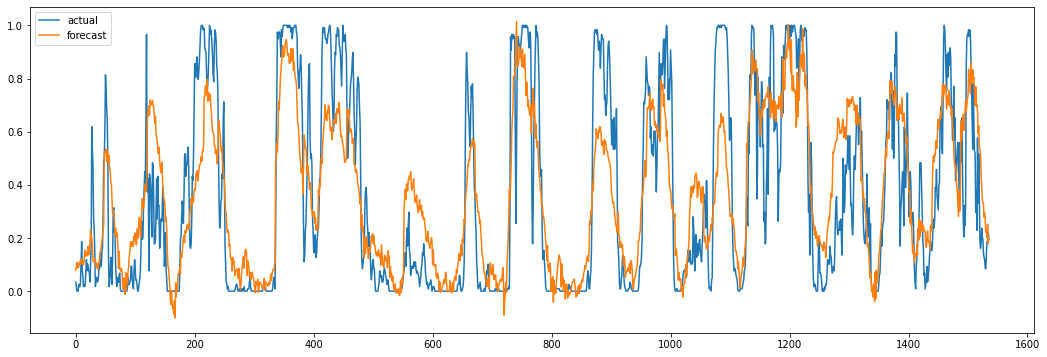

In [120]:
x_test, y = next(window.test.as_numpy_iterator())
y_pred = model.predict(x_test)

plt.figure(figsize=(18, 6))
plant_id = 9

plt.plot(y[:, :, plant_id, 0].flatten())
plt.plot(y_pred[:, :, plant_id].flatten())
plt.legend(["actual", "forecast"])

In [128]:
from utils.tf_helpers import calculate_plantwise_wmape

In [129]:
calculate_plantwise_wmape(model, window, plants)

,rt_plant_id,wmape,wmape_val
23,1503,0.295084,0.409294
13,1489,0.299785,0.324802
69,2058,0.310478,0.297737
4,969,0.315020,0.236325
80,2116,0.319341,0.246234
...,...,...,...
75,2089,0.682302,0.532632
76,2104,0.722321,0.477047
1,749,0.736676,0.963803
38,1523,0.817943,0.278473


In [ ]:
inp_seq = Input((sequence_length, 10))
inp_lap = Input((10, 10))
inp_feat = Input((10, X_train_feat.shape[-1]))
x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
x = GraphConv(16, activation='relu')([x, inp_lap])
x = Flatten()(x)
xx = LSTM(128, activation='relu',return_sequences=True)(inp_seq)
xx = LSTM(32, activation='relu')(xx)
x = Concatenate()([x,xx])
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1)(x)
model = Model([inp_seq, inp_lap, inp_feat], out)